In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "your_id"
#   - kssl v1 mirs: "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG"
#   - kssl v2 mirs: "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT"
#   - seibersdorf mirs: "1-N4pziF8YvMTvUYljVAKLVvayYmf6NeB"
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [1]:
!pip install spanda

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 35.5 MB/s eta 0:00:00
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=3a5ec1c08d248858236033338b04d61fbeb64cedb9833df8e413bebab6670437
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm,
                                    ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

analyte_name = 725

In [4]:
# Only samples with spectra
path = Path('/root/kssl-mirs-v2'); path.ls()
#path = Path('../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('/root/kssl-mirs-v2/174608'),Path('/root/kssl-mirs-v2/174916'),Path('/root/kssl-mirs-v2/19897'),Path('/root/kssl-mirs-v2/68409'),Path('/root/kssl-mirs-v2/86746'),Path('/root/kssl-mirs-v2/172147'),Path('/root/kssl-mirs-v2/199430'),Path('/root/kssl-mirs-v2/180551'),Path('/root/kssl-mirs-v2/25251'),Path('/root/kssl-mirs-v2/176480')...]

In [5]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 46305/46305 [00:02<00:00, 22616.83it/s]

n samples: 46251


In [6]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [7]:
# Only strictly positive measurements
paths = [p for p in paths if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

n samples: 44565


In [32]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm, GADFTfm, ResizeTfm(256),
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
#dls.show_batch()

In [29]:
dls.one_batch()[0][0].shape

torch.Size([1, 256, 256])

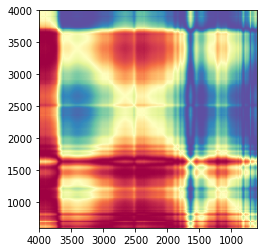

In [30]:
plt.imshow(dls.one_batch()[0][0].squeeze().cpu(), cmap='Spectral', 
           origin='upper', extent=[4000,600,600,4000]);

In [ ]:
# Inside vision_learner (Jarvis Labs): https://www.youtube.com/watch?v=mQMwJU4H3G8

In [ ]:
#model = create_timm_model('resnet34', pretrained=True, in_chans=1)

In [ ]:
# I have to cut/create head 1
#model = timm.create_model('resnet34', pretrained=True, in_chans=1)

In [ ]:
#learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

In [ ]:
#learn2 = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [34]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [17]:
learn.summary()

Sequential (Input shape: 32 x 1 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.004365158267319202)

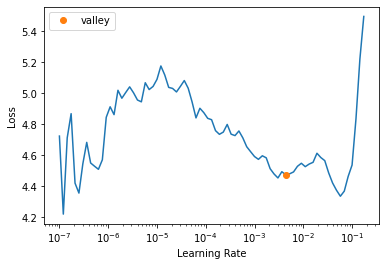

In [35]:
learn.lr_find()

In [36]:
learn.fine_tune(20, 1e-2)

epoch,train_loss,valid_loss,r2_score,time
0,0.169851,0.112278,0.513433,06:02


epoch,train_loss,valid_loss,r2_score,time
0,0.086819,0.074043,0.679127,06:20
1,0.076483,0.070027,0.696529,06:11
2,0.070250,0.080275,0.652120,05:58
3,0.074822,0.074860,0.675585,06:06
4,0.069246,0.064235,0.721632,06:21
5,0.068235,0.066219,0.713031,06:20
6,0.063127,0.055640,0.758877,06:15
7,0.059945,0.055468,0.759623,06:15
8,0.057103,0.063794,0.723544,06:11
9,0.049702,0.054412,0.764198,06:37


In [37]:
learn.save('xresnet18-kex-mirs-kssl-20-epochs-gadf-05052023')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-gadf-05052023.pth')